In [73]:
### import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import time
import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf

import warnings
warnings.filterwarnings(action='ignore')

In [74]:
### Data Crawling from Fnguide 
def load_FS():
    print("자료의 소스는 FnGuide, 네이버금융, Yahoo Finance입니다.해당 사이트들에 필요한 정보가 누락되어있으면 valuation을 중단합니다.\n")
    company = input("종목코드를 입력하세요: ")
    source_url = 'https://comp.fnguide.com/SVO2/asp/SVD_Finance.asp?pGB=1&gicode=A{0}&cID=&MenuYn=Y&ReportGB=&NewMenuID=103&stkGb=701'.format(company)
    tables = pd.read_html(source_url, encoding='utf-8')
    
    IS = tables[0]
    BS = tables[2]
    CF = tables[4]
    
    return company, IS, BS, CF

In [75]:
# 최근 4년치 FCFF산출
class step1:
    def __init__(self, company, IS, BS, CF):
        self._company = company
        self._IS = IS
        self._BS = BS
        self._CF = CF
        self._tax = 0
        self._sales = [] 
        self._cogs = []
        self._sgna = []
        self._op = []
        self._capex_l = []
        self._dep_l = []
        self._amo_l = []
        self._dNWC = [0]
        self._FCFF = []
        self._NWC = []
        
    
    def Basic_IS(self):

        IS_core = self._IS.loc[[0,1,3],['IFRS(연결)','2021/12','2022/12','2023/12']]
        self._sales = list(IS_core.loc[0])
        self._cogs = list(IS_core.loc[1])
        self._sgna = list(IS_core.loc[3])

        self._sales.pop(0)
        self._cogs.pop(0)
        self._sgna.pop(0)

        # 매출액에 따라 tax율 다름. 지방소득세 10%추가
        for i in range(3):
            if self._sales[i] > 3000:
                self._tax = 0.275
            elif 200 < self._sales[i] <= 3000:
                self._tax = 0.242
            elif 2 < self._sales[i] <= 200:
                self._tax = 0.22
            else :
                self._tax = 0.11
            
            # EBIT 산출
            self._op.append((self._sales[i]-self._cogs[i]-self._sgna[i])*(1-self._tax))
        
        return self._tax
    
    
    def Basic_CF(self): 


        url = 'https://comp.fnguide.com/SVO2/asp/SVD_Finance.asp?pGB=1&gicode=A{0}&cID=&MenuYn=Y&ReportGB=&NewMenuID=103&stkGb=701'.format(self._company)
        response = requests.get(url)

        if response.status_code == 200:
            html = response.text
            soup = BeautifulSoup(html, 'html.parser')
            capex = soup.select_one('#divCashY > table > tbody > tr:nth-child(108)')
            dep = soup.select_one('#divCashY > table > tbody > tr:nth-child(9)')
            amo =  soup.select_one('#divCashY > table > tbody > tr:nth-child(10)')
        else : 
            print(response.status_code)


        capex = capex.get_text()
        dep = dep.get_text()
        amo = amo.get_text()

        n = re.compile('\d+\,?\d+')
        self._capex_l = n.findall(capex)
        self._dep_l = n.findall(dep)
        self._amo_l = n.findall(amo)

        # 마지막 24년도 1분기 데이터는 제외시키자
        self._capex_l.pop(3)
        self._dep_l.pop(3)
        self._amo_l.pop(3)

        for i in range(3):
            self._capex_l[i] = int(self._capex_l[i].replace(',',''))
            self._dep_l[i] = int(self._dep_l[i].replace(',',''))
            self._amo_l[i] = int(self._amo_l[i].replace(',',''))



    def Dnwc(self):
        url = 'https://comp.fnguide.com/SVO2/asp/SVD_Finance.asp?pGB=1&gicode=A{0}&cID=&MenuYn=Y&ReportGB=&NewMenuID=103&stkGb=701'.format(self._company)
        response = requests.get(url)

        if response.status_code == 200:
            html = response.text
            soup = BeautifulSoup(html, 'html.parser')
            AR_r = soup.select_one('#divDaechaY > table > tbody > tr:nth-child(6)').get_text()
            Inventory_r =  soup.select_one('#divDaechaY > table > tbody > tr:nth-child(3)').get_text()
            CA_etc_r =  soup.select_one('#divDaechaY > table > tbody > tr:nth-child(11)').get_text()
            AP_r = soup.select_one('#divDaechaY > table > tbody > tr:nth-child(35)').get_text()
            CL_etc_r = soup.select_one('#divDaechaY > table > tbody > tr:nth-child(42)').get_text()
        else : 
            print(response.status_code)

        ft = re.compile('\d+\,?\d+')

        AR = ft.findall(AR_r)
        Inventory = ft.findall(Inventory_r)
        CA_etc = ft.findall(CA_etc_r)
        AP = ft.findall(AP_r)
        CL_etc = ft.findall(CL_etc_r)

        for i in range(len(AR)):
            AR[i] = int(AR[i].replace(',',''))
            Inventory[i] = int(Inventory[i].replace(',',''))
            CA_etc[i] = int(CA_etc[i].replace(',',''))
            AP[i] = int(AP[i].replace(',',''))
            CL_etc[i] = int(CL_etc[i].replace(',',''))
            self._NWC.append((AR[i]+Inventory[i]+CA_etc[i]) - (AP[i]+CL_etc[i]))

        # 마지막 24년 1분기 데이터는 제외시킴
        self._NWC.pop(3)


        for i in range(len(self._op)):
            if i < len(self._op) - 1:
                self._dNWC.append(self._NWC[i+1]-self._NWC[i])
        


    def FCFF(self):
    
        for i in range(3):
            self._FCFF.append(self._op[i]+self._dep_l[i]+self._amo_l[i]-self._capex_l[i]-self._dNWC[i])



    def mktable(self):
        
        d_main_info = {'매출액': self._sales,'매출원가': self._cogs,'판관비': self._sgna
                 ,'영업이익': self._op,'+유형자산상각비':self._dep_l,'+무형자산상각비': self._amo_l,
                   '-Capex': self._capex_l,'-dNwc': self._dNWC, 'FCFF': self._FCFF, '참고용NWC': self._NWC}
        
        print(d_main_info)

        yr1 = (datetime.datetime.today() - relativedelta(years = 1)).strftime("%Y")
        yr2 = (datetime.datetime.today() - relativedelta(years = 2)).strftime("%Y")
        yr3 = (datetime.datetime.today() - relativedelta(years = 3)).strftime("%Y")
   
        Main_info = pd.DataFrame(d_main_info, index=[yr3, yr2 ,yr1]) 


        S_BS = Main_info.transpose()
        print("최근 3개년 FCFF(단위: 억)")
        display(S_BS)
        print("첫 번째 열의 dNWC의 경우 해당 페이지에서 얻을 수 없으며, 미래 추정에 영향을 주지 않음\n ")
        return S_BS


In [76]:
### 5개년치 추정
class step2:
    
    def __init__(self,table,tax):
        
        self._table = table
        self._tax = tax
        self._cagr =  0
        self._cogs_avg = 0
        self._sgna_avg = 0
        self._capex_ratio = 0
        self._dep_ratio = 0
        self._amo_ratio = 0
        self._NWC_ratio = 0



    def ratios(self):
        
        self._cagr = round((self._table.iloc[0][2]/self._table.iloc[0][0])**(1/2) - 1,2)
        
        for i in range(3):
            self._cogs_avg += (self._table.iloc[1][i]/self._table.iloc[0][i])/len(self._table.iloc[0])
            self._sgna_avg += (self._table.iloc[2][i]/self._table.iloc[0][i])/len(self._table.iloc[0])
            self._capex_ratio += (self._table.iloc[6][i]/self._table.iloc[0][i])/len(self._table.iloc[0])
            self._dep_ratio += (self._table.iloc[4][i]/self._table.iloc[0][i])/len(self._table.iloc[0])
            self._amo_ratio += (self._table.iloc[5][i]/self._table.iloc[0][i])/len(self._table.iloc[0])
            self._NWC_ratio += (self._table.iloc[9][i]/self._table.iloc[3][i])/len(self._table.iloc[3])


    ### 중요!!!
    ## 2번이 nan값 --> 매출원가가 없는 서비스기업 --> 판관비에 매출원가 포함되므로 0%로 조정
    ## 최근 4년간 재무제표를 보고 outlier라 판단되면 제거후 조정함. 특히 7번!!
    def Assume(self):
        
        print("각 항목들이 다음의 수치를 기반으로 추정됩니다.\n")
    
        print("1. {0:15} :{1}%".format('매출-연평균 매출성장률',round(self._cagr*100,2)))
        print("2. {0:15} :{1}%".format('매출원가-평균 매출원가율', round(self._cogs_avg*100,2)))
        print("3. {0:15} :{1}%".format('판매관리비-평균 판관비율',round(self._sgna_avg*100,2)))
        print("4. {0:15} :{1}%".format('자본적지출-매출대비비중',round(self._capex_ratio*100,2)))
        print("5. {0:15} :{1}%".format('유형자산상각비-매출대비비중',round(self._dep_ratio*100,2)))
        print("6. {0:15} :{1}%".format('무형자산상각비-매출대비비중',round(self._amo_ratio*100,2)))
        print("7. {0:15} :{1}%".format('순운전자본-영업이익대비비중',round(self._NWC_ratio*100,2)))
        
        while (1):
            
            try:
                q1 = input("\n신규추정을 할 항목의 번호를 입력하세요(0 입력시 기본수치로 진행): ")

                if q1 == '0':
                    break
                elif q1 == '1':
                    self._cagr = float(input("신규추정치를 입력하세요(%): "))/100.0
                elif q1 == '2':
                    self._cogs_avg = float(input("신규추정치를 입력하세요(%): "))/100.0

                elif q1 == '3':
                    self._sgna_avg = float(input("신규추정치를 입력하세요(%): "))/100.0

                elif q1 == '4':
                    self._capex_ratio = float(input("신규추정치를 입력하세요(%): "))/100.0

                elif q1 == '5':
                    self._dep_ratio = float(input("신규추정치를 입력하세요(%): "))/100.0

                elif q1 == '6':
                    self._amo_ratio = float(input("신규추정치를 입력하세요(%): "))/100.0

                elif q1 == '7':
                    self._NWC_ratio = float(input("신규추정치를 입력하세요(%): "))/100.0
                
                else: 
                    raise ValueError
            except:
                print("Erorr!: 잘못된 값을 입력했습니다. 0~7의 숫자만 입력하세요")
            
        print("\n__________________________________________________________________________________________")
        print("신규 추정치\n")
    
        print("1. {0:15} :{1}%".format('매출-연평균 매출성장률',round(self._cagr*100,2)))
        print("2. {0:15} :{1}%".format('매출원가-평균 매출원가율', round(self._cogs_avg*100,2)))
        print("3. {0:15} :{1}%".format('판매관리비-평균 판관비율',round(self._sgna_avg*100,2)))
        print("4. {0:15} :{1}%".format('자본적지출-매출대비비중',round(self._capex_ratio*100,2)))
        print("5. {0:15} :{1}%".format('유형자산상각비-매출대비비중',round(self._dep_ratio*100,2)))
        print("6. {0:15} :{1}%".format('무형자산상각비-매출대비비중',round(self._amo_ratio*100,2)))
        print("7. {0:15} :{1}%".format('순운전자본-영업이익대비비중',round(self._NWC_ratio*100,2)))
        print("__________________________________________________________________________________________")

                

    def forecast(self):
        
        F_sales =[]
        F_cogs = []
        F_sgna = []
        F_op =[]
        F_capex =[]
        F_dep = []
        F_amo = []
        F_dnwc = []
        F_FCFF = []
        F_NWC = []
        
        
        for i in range(5):
            if i == 0:
                F_sales.append(round(self._table.iloc[0][2]*(1+self._cagr),1))
                F_cogs.append(round(F_sales[i]*self._cogs_avg,1))
                F_sgna.append(round(F_sales[i]*self._sgna_avg,1))
                F_op.append(round(F_sales[i]-F_cogs[i]-F_sgna[i])*(1-self._tax))
                F_capex.append(round(F_sales[i]*self._capex_ratio,1))
                F_dep.append(round(F_sales[i]*self._dep_ratio,1))
                F_amo.append(round(F_sales[i]*self._amo_ratio,1))
                F_NWC.append(round(F_op[i]*self._NWC_ratio,1))
                F_dnwc.append(round(F_NWC[i]-self._table.iloc[9][2],1))
                F_FCFF.append(round(F_op[i]+F_dep[i]+F_amo[i]-F_capex[i]-F_dnwc[i],1))
            else:
                F_sales.append(round(F_sales[i-1]*(1+self._cagr),1))
                F_cogs.append(round(F_sales[i]*self._cogs_avg,1))
                F_sgna.append(round(F_sales[i]*self._sgna_avg,1))
                F_op.append(round(F_sales[i]-F_cogs[i]-F_sgna[i])*(1-self._tax))
                F_capex.append(round(F_sales[i]*self._capex_ratio,1))
                F_dep.append(round(F_sales[i]*self._dep_ratio,1))
                F_amo.append(round(F_sales[i]*self._amo_ratio,1))
                F_NWC.append(round(F_op[i]*self._NWC_ratio,1))
                F_dnwc.append(round(F_NWC[i]-F_NWC[i-1],1))
                F_FCFF.append(round(F_op[i]+F_dep[i]+F_amo[i]-F_capex[i]-F_dnwc[i],1))

            
            
        dFIS = {'매출액': F_sales,'매출원가': F_cogs,'판관비': F_sgna
             ,'영업이익': F_op,'+유형자산상각비':F_dep,'+무형자산상각비': F_amo,
               '-Capex': F_capex,'-dNwc': F_dnwc, 'FCFF': F_FCFF}
        
        fyr1 = (datetime.datetime.today()).strftime("%Y")+'F'
        fyr2 = (datetime.datetime.today() + relativedelta(years = 1)).strftime("%Y")+'F'
        fyr3 = (datetime.datetime.today() + relativedelta(years = 2)).strftime("%Y")+'F'
        fyr4 = (datetime.datetime.today() + relativedelta(years = 3)).strftime("%Y")+'F'
        fyr5 = (datetime.datetime.today() + relativedelta(years = 4)).strftime("%Y")+'F'

        ISFt = pd.DataFrame(dFIS, index = [fyr1, fyr2, fyr3, fyr4, fyr5]) 
        
        FIS=ISFt.transpose()
        print("추정 5개년 FCFF(단위: 억)")
        display(FIS)
        return FIS


In [77]:
class WACC:
    
    print("\n__________________________________________________________________________________________")
    print("WACC는 가중평균 자본비용으로 미래 가치들에 대한 할인율로 이용된다.")
    
    def __init__(self, company, BS, tax):
        
        self._company = company
        self._BS = BS
        self._tax = tax
        self._Rf = 0
        self._Rm = 0
        self._beta = 0
        self._kd = 0
        self._ke = 0 
        
    def risk_free_rate(self):
        
        # 연도별로 xlsx 업데이트 필요 (2019~2023)
        #'https://www.index.go.kr/unity/potal/main/EachDtlPageDetail.do?idx_cd=1073#'
        tables = pd.read_excel('/Users/hw/서강대학부자료/Quantifi/금융보고서스터디/2024국고채.xlsx')
        rf_r = tables.iloc[3:4, 4:9]
        b5y = rf_r.values.flatten().tolist()

        # 국고채 5년 수익률의 가중평균
        for i in range(len(b5y)):
            self._Rf += b5y[i]/len(b5y)

        self._Rf = round(self._Rf/100,4)
        print("Rf : 무위험 수익률")
        print("한국 국고채 5년 평균 수익률: {}%\n".format(str(round(self._Rf*100,3))))
        return self._Rf
    
    def market_risk_premium(self):

        KOSPI = yf.download('^KS11', start="2019-01-01",end="2023-12-31")['Adj Close']
        returns = KOSPI.pct_change()

        self._Rm = round(returns.mean() * 252, 3)

        print("Rm : 시장 수익률")
        print("KOSPI 5년 평균 수익률: {}%\n".format(str(round(self._Rm*100,3))))
        
        return self._Rm


        '''
        # 연도별로 xlsx 업데이트 필요 (2019~2023)
        #'https://finance.yahoo.com/quote/%5EKS11/history?frequency=1mo&period1=1557132568&period2=1714985072'
        
        tables = pd.read_csv('/Users/hw/서강대학부자료/Quantifi/금융보고서스터디/24코스피.csv')

        tables['pct_year'] = tables['Close'].pct_change()
        
        # 일별수익률의 평균을 구한 후 연수익률로 환산
        self._Rm = round(tables['pct_year'].mean() * 252, 3)
        
        print("Rm : 시장 수익률")
        print("KOSPI 5년 평균 수익률: {}%\n".format(str(round(self._Rm*100,3))))
        return self._Rm
        '''
        
    def beta(self):
        
        tickers = ['^KS11', self._company + '.KS']

        price = pd.DataFrame()
        for items in tickers:
            price[items] = yf.download(items, start="2019-01-01",end="2023-12-31")['Adj Close']

        returns = price.pct_change()
        
        covs = returns.cov()
        covs = covs.loc['^KS11', self._company + '.KS']

        import math
        var_KOSPI = returns['^KS11'].var()

        self._beta = covs / var_KOSPI
        
        print("Beta : 회사주가와 시장지수의 상관계수")
        print("Leverd Beta: {}\n".format(self._beta))
        
        
        print(">>>>Re(자기자본비용) = Rf + Beta(Rm-Rf)\n\n ")
        return self._beta
        
    
    def cost_debt(self):
        
        source_url = 'https://www.kisrating.com/ratingsStatistics/statics_spread.do'
        tables = pd.read_html(source_url, encoding='utf-8')
        self._kd_r = tables[0]
        self._kd_r.index = list(self._kd_r.iloc[:,0])
        self._kd_r = self._kd_r.drop(['구분','3월','6월','9월','1년','1년6월','2년','3년'],axis = 1)
        
        credit = input("회사신용등급입력: 국고채, AAA, AA+, AA, AA-, A+, A, A-, BBB+, BBB, BBB-")
        
        print(self._kd_r)

        self._kd = self._kd_r.loc[credit, '5년']/100
        
        print("Kd(타인자본비용)")
        print("{0} 등급 회사채 수익률: {1}%\n".format(credit, str(round(self._kd*100,3))))
              
        return self._kd

    def wacc(self):
        
        equity_ratio = round(self._BS.iloc[8,4]/self._BS.iloc[0,4],4)
        debt_ratio = 1 - equity_ratio
        self._ke = self._Rf+self._beta*(self._Rm-self._Rf)

        print("Ke(자기자본비용): {}%\n".format(str(round(self._ke*100, 3))))
        
        wacc = self._kd*(1-self._tax)*debt_ratio + self._ke*equity_ratio
        print("WACC = Re*자본비율 + Ke(1-tax)*부채비율")
        print("WACC(가중평균자본비용): {}%".format(str(round(wacc*100,2))))
        return wacc



__________________________________________________________________________________________
WACC는 가중평균 자본비용으로 미래 가치들에 대한 할인율로 이용된다.


In [78]:
class DCF:
    
    
    def __init__(self, forecast, wacc, company):
        
        self._forecast = forecast
        self._wacc = wacc
        self._company = company
        self._stockvalue = 0
        
        self._pv_FCFF = 0
        self._TV = 0
        self._pv_TV = 0
        self._net_NOA = 0
        self._Pg = 0
        self._TV_t = 0
        self._PVTV_t = 0
        self._pvfcff_t = 0
        self._stock_value_t = 0
        
        
    def pv_FCFF(self):
        
        sen_t = []
        index = []
        
        for i in range(5):
                self._pv_FCFF += self._forecast.loc['FCFF'][i]/((1+self._wacc)**(i+1))
                
        for j in range(-2,3):
            t_pv_FCFF = 0
            tmp_wacc = (self._wacc + (j/100))*100
            index.append(str(round(tmp_wacc,2))+'%')
            for i in range(len(self._forecast.loc['FCFF'])):
                t_pv_FCFF += self._forecast.loc['FCFF'][i]/((1+self._wacc+(j/100))**(i+1))
            sen_t.append(round(t_pv_FCFF,1))
            
            
        self._pvfcff_t = pd.DataFrame(sen_t, index = index)
        self._pvfcff_t = self._pvfcff_t.transpose()
        self._pvfcff_t.index = ['PV of FCFF']
        print("__________________________________________________________________________________________")
        print("\n\nPV of FCFF 민감도 분석 테이블")
        display(self._pvfcff_t)
        print("WACC : {}".format(str(round(self._wacc*100,2))+'%'))
        
        return self._pv_FCFF
    
    ### 중요!!!
    ## TV가 inf나 음수가 나오면 영구성장률이 너무 높은 것!!
    def TV(self):
       
        t_data = []
        columns = []
        index = []
        print("\n\n영구성장률은 추정 마지막 년도 이후에 회사의 성장률입니다. 보통 0% ~ 2%가 적절한 값입니다.")
        
        try:
            self._Pg = float(input("영구성장률을 입력하세요(%): "))/100
            
            if self._wacc-self._Pg <= 0:
                raise ValueError
            
        except ValueError:
            print("Erorr!: 잘못된 값을 입력했습니다. 숫자를 입력하세요.")
            self._Pg = float(input("영구성장률을 입력하세요(%): "))/100
        
        try:
            self._TV = self._forecast.loc['FCFF'][4]*(1+self._Pg)/(self._wacc-self._Pg)
        except ZeroDivisionError:
            
            print("Erorr!: wacc와 Pg의 차이가 거의 나지 않습니다. Pg를 다시 설정해주세요.")
            self._Pg = float(input("영구성장률을 입력하세요(%): "))/100
        
        for i1 in range(-2,3):
            r_data = []
            pg = self._Pg + (i1/200)
            index.append(str(round(100*pg,1))+'%')
            columns.append(str(round(100*(self._wacc+(i1/100)),2))+'%')
            for i2 in range(-2,3,1):
                wacc = self._wacc + (i2/100)
                TV = (self._forecast.loc['FCFF'][4]*(1+pg))/round(wacc-pg,2)
                r_data.append(round(TV,2))
                
            
            t_data.append(r_data)
                    
            
        self._pv_TV = self._TV/((1+self._wacc)**5)
        
        self._TV_t = pd.DataFrame(t_data, index=index, columns = columns)
        
        self._PVTV_t = pd.DataFrame(index=index, columns = columns)
        
        for j1 in range(5):
        
            for j2 in range(-2,3):
                wacc = self._wacc + (j2/100)
                self._PVTV_t.iloc[j1][j2+2] = round(self._TV_t.iloc[j1][j2+2]/((1+wacc)**5),2)
        print("__________________________________________________________________________________________")        
        print("\nTV 및 PV of TV 민감도 분석 테이블")       
        print("WACC : {}% 영구성장률: {}%".format(str(round(self._wacc*100,2)),str(round(self._Pg*100,2))))
        display(self._TV_t)
        display(self._PVTV_t)

    
    def NOA_IBD(self, BS):
        
        IBD_L = BS.iloc[6, 4]
        NOA = BS.iloc[2, 4]

        self._net_NOA =  NOA - IBD_L 
        
        
    def EV(self):      

        stock = yf.Ticker(self._company + '.KS')
        info = stock.info
        share_outstanding = info['sharesOutstanding']

        Enterprise_value = self._pv_FCFF + self._pv_TV
        
        Equity_value =  Enterprise_value + self._net_NOA
        stock_value = (Equity_value*100000000)/share_outstanding
        
        Enterprise_value_t = pd.DataFrame(index = list(self._PVTV_t.index),columns = list(self._PVTV_t.columns)) 
        Equity_value_t = pd.DataFrame(index = list(self._PVTV_t.index),columns = list(self._PVTV_t.columns))
        self._stock_value_t = pd.DataFrame(index = list(self._PVTV_t.index),columns = list(self._PVTV_t.columns))
        for i1 in range(5):
            for i2 in range(5):
                Enterprise_value_t.iloc[i1][i2] = self._PVTV_t.iloc[i1][i2] + self._pvfcff_t.iloc[0][i2]
                Equity_value_t.iloc[i1][i2] = Enterprise_value_t.iloc[i1][i2] + self._net_NOA
                self._stock_value_t.iloc[i1][i2] = round(((Enterprise_value_t.iloc[i1][i2] + self._net_NOA)*100000000)/share_outstanding)
        
        self._stockvalue = self._stock_value_t.iloc[2][2]
        
        print("__________________________________________________________________________________________")        
        
        print("회사 가치(단위: 억)")
        display(Enterprise_value_t)
        
        print("회사의 자산 가치(단위: 억)")
        display(Equity_value_t)
        
        print("회사의 주가 가치(단위: 원)")
        display(self._stock_value_t)
        
        print("DCF평가법을 통한 {}의 주가는 {}원 입니다.\n".format(self._company, self._stockvalue))
        
        return self._stockvalue, self._stock_value_t



In [79]:
class analysis:
    
    def __init__(self, company, stockvalue, BS, FIS, stockvalue_t):
        self._company = company
        self._stockvalue = stockvalue
        self._stock_value_t = stockvalue_t
        self._stockprice = 0
        self._concensus = ''
        self._BS = BS
        self._FIS = FIS
    
    def today_stockprice(self):
        
        stock = yf.download(self._company + '.KS')['Adj Close'].tail(n=1).iloc[0]
        
        self._stockprice = stock
        
        print("__________________________________________________________________________________________")        
    
        print("전일 종가는 {}원 입니다.".format(self._stockprice))
        return self._stockprice
    
    def visualization(self):
        
        wacc = self._stock_value_t.columns[2]
        pg = self._stock_value_t.index[2]
        
        x = np.arange(5)
        
        pg_s = list(self._stock_value_t.index)
        price1 = list(self._stock_value_t.iloc[:][wacc])
        wacc_s = list(self._stock_value_t.columns)
        price2 = list(self._stock_value_t.iloc[2][:])
        
        
        f1 = plt.figure()
        plt.title('Price trend by Pg')
        plt.bar(x, price1)
        plt.xticks(x, labels = pg_s)
        plt.annotate("previous close", xy = (3,self._stockprice), xytext = (3.25,0.85*self._stockprice), 
                     arrowprops=dict(arrowstyle="-", linewidth=1, color='r'))
        plt.xlabel('Perpetual growth rate')
        plt.ylabel('stock Price')
        plt.axhline(self._stockprice,0, 1, color = 'r')
        
        for i, v in enumerate(x):
                plt.text(v, price1[i], price1[i], fontsize = 9,color='k',
                 horizontalalignment='center',verticalalignment='bottom')    
        
        f2 = plt.figure()
        plt.title('Price trend by Wacc')
        plt.bar(x, price2)
        plt.xticks(x, labels = wacc_s)
        plt.annotate("previous close", xy = (3,self._stockprice), xytext = (3.25,0.85*self._stockprice), 
                     arrowprops=dict(arrowstyle="-", linewidth=1, color='r'))
        plt.xlabel('WACC')
        plt.ylabel('stock Price')
        plt.axhline(self._stockprice,0, 1, color = 'r')
        for i, v in enumerate(x):
                plt.text(v, price2[i], price2[i], fontsize = 9,color='k',
                 horizontalalignment='center',verticalalignment='bottom')

                
        f3 = plt.figure()
        value = [self._stock_value_t.iloc[0][4],self._stock_value_t.iloc[1][3],
                    self._stockvalue,self._stockprice,self._stock_value_t.iloc[3][1],self._stock_value_t.iloc[4][0]]
        x = [0,0.25,0.5,0.5,0.75,1]
        plt.title('Target Zone')
        plt.scatter(x,value)
        plt.xlabel('Pg-WACC')
        plt.ylabel('stock Price')
        span_start = self._stockprice
        span_end = 1.4*self._stockprice
        plt.axhspan(span_start, span_end, facecolor='r', alpha = 0.3)
        plt.annotate("Target Zone", xy = (0.5,self._stockprice), xytext = (0.6,0.85*self._stockprice), 
                     arrowprops=dict(arrowstyle="-", linewidth=1, color='r'))
        for i, v in enumerate(x):
            plt.text(v, value[i], value[i], fontsize = 9,color='k',
            horizontalalignment='center',verticalalignment='bottom')

        plt.show()
        print("#3번 그래프: x축 진행방향으로 갈수록 pg와 wacc 격차가 축소됨\n\n")

       
    def concensus(self):
        
        potential = round((self._stockvalue/self._stockprice - 1)*100,2)
        
        if potential >= 40:
            self._concensus = 'too high'
        elif potential >= 10:
            self._concensus = 'Buy'
        
        elif  0 <= potential < 10:
            self._concensus = 'Hold'
        
        elif potential <= 0:
            self._concensus = 'Sell'
        
        print("산출된 주가 - 현재 주가 = {}".format(self._stockvalue-self._stockprice))
        print("potentail = {}%".format(potential))
        print("최종 의견: {}".format(self._concensus))
        return self._concensus
    
    def advise(self):
        
        if self._concensus == 'Sell':
                print("\n현재 가정하에 미래 현금흐름이 부족합니다.\n")
                
                if (self._FIS.iloc[0][4]/self._FIS.iloc[0][0] - 1) > (self._FIS.iloc[8][4]/self._FIS.iloc[8][0] - 1):
                    print("수익성 개선이 필요합니다. 매출원가율, 판관비율을 줄일 필요가 있습니다.")
                    print("재고자산 회전율을 높이고 매출채권 비중을 낮춰야합니다. 또 미지급금을 줄여서 최종적으로 NWC를 낮춰야합니다.")
                    
                elif (self._FIS.iloc[0][4]/self._FIS.iloc[0][0] - 1) < (self._FIS.iloc[8][4]/self._FIS.iloc[8][0] - 1):
                    print("매출 성장률이 더 높아야 합니다.")
                   
        elif self._concensus == 'too high':
            print("비현실적인 가정일 가능성이 높습니다. 수치 재조정이 권장됩니다.")

In [80]:
'''
class MonteCarlo:

    def __init__(self,):
        self.
        self.
        self.
'''

'\nclass MonteCarlo:\n\n    def __init__(self,):\n        self.\n        self.\n        self.\n'


------------------------------------------------
자료의 소스는 FnGuide, 네이버금융, Yahoo Finance입니다.해당 사이트들에 필요한 정보가 누락되어있으면 valuation을 중단합니다.

{'매출액': [2796048.0, 3022314.0, 2589355.0], '매출원가': [1664113.0, 1900418.0, 1803886.0], '판관비': [615596.0, 688130.0, 719799.0], '영업이익': [374345.77499999997, 314480.35, 47610.75], '+유형자산상각비': [312852, 359521, 355324], '+무형자산상각비': [29622, 31556, 31341], '-Capex': [471221, 494304, 576113], '-dNwc': [0, 81947, 47304], 'FCFF': [245598.7749999999, 129306.34999999998, -189141.25], '참고용NWC': [330356, 412303, 459607]}
최근 3개년 FCFF(단위: 억)


,2021,2022,2023
매출액,2796048.000,3022314.00,2589355.00
매출원가,1664113.000,1900418.00,1803886.00
판관비,615596.000,688130.00,719799.00
영업이익,374345.775,314480.35,47610.75
+유형자산상각비,312852.000,359521.00,355324.00
+무형자산상각비,29622.000,31556.00,31341.00
-Capex,471221.000,494304.00,576113.00
-dNwc,0.000,81947.00,47304.00
FCFF,245598.775,129306.35,-189141.25
참고용NWC,330356.000,412303.00,459607.00


첫 번째 열의 dNWC의 경우 해당 페이지에서 얻을 수 없으며, 미래 추정에 영향을 주지 않음
 
각 항목들이 다음의 수치를 기반으로 추정됩니다.

1. 매출-연평균 매출성장률    :-4.0%
2. 매출원가-평균 매출원가율   :64.02%
3. 판매관리비-평균 판관비율   :24.19%
4. 자본적지출-매출대비비중    :18.49%
5. 유형자산상각비-매출대비비중  :12.27%
6. 무형자산상각비-매출대비비중  :1.1%
7. 순운전자본-영업이익대비비중  :394.9%

__________________________________________________________________________________________
신규 추정치

1. 매출-연평균 매출성장률    :-4.0%
2. 매출원가-평균 매출원가율   :64.02%
3. 판매관리비-평균 판관비율   :24.19%
4. 자본적지출-매출대비비중    :18.49%
5. 유형자산상각비-매출대비비중  :12.27%
6. 무형자산상각비-매출대비비중  :1.1%
7. 순운전자본-영업이익대비비중  :100.0%
__________________________________________________________________________________________
추정 5개년 FCFF(단위: 억)


,2024F,2025F,2026F,2027F,2028F
매출액,2485780.800,2386349.600,2290895.60,2199259.800,2111289.400
매출원가,1591410.400,1527754.000,1466643.90,1407978.100,1351659.000
판관비,601421.000,577364.200,554269.60,532098.800,510814.900
영업이익,212388.025,203892.475,195736.95,187907.675,180390.875
+유형자산상각비,304981.500,292782.200,281070.90,269828.100,259035.000
+무형자산상각비,27458.800,26360.400,25306.00,24293.800,23322.000
-Capex,459517.700,441137.000,423491.50,406551.800,390289.800
-dNwc,-247219.000,-8495.500,-8155.60,-7829.200,-7516.800
FCFF,332529.600,90393.600,86777.90,83307.000,79974.900


Rf : 무위험 수익률
한국 국고채 5년 평균 수익률: 2.29%



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Rm : 시장 수익률
KOSPI 5년 평균 수익률: 7.5%



[*********************100%%**********************]  1 of 1 completed


Beta : 회사주가와 시장지수의 상관계수
Leverd Beta: 1.0214211621226472

>>>>Re(자기자본비용) = Rf + Beta(Rm-Rf)

 
         5년
국고채    3.15
AAA    3.48
AA+    3.55
AA     3.61
AA-    3.72
A+     4.53
A      4.98
A-     5.58
BBB+   7.53
BBB    8.58
BBB-  10.00
Kd(타인자본비용)
AAA 등급 회사채 수익률: 3.48%

Ke(자기자본비용): 7.612%

WACC = Re*자본비율 + Ke(1-tax)*부채비율
WACC(가중평균자본비용): 6.54%
__________________________________________________________________________________________


PV of FCFF 민감도 분석 테이블


,4.54%,5.54%,6.54%,7.54%,8.54%
PV of FCFF,610536.7,598241.2,586410.7,575021.1,564050.0


WACC : 6.54%


영구성장률은 추정 마지막 년도 이후에 회사의 성장률입니다. 보통 0% ~ 2%가 적절한 값입니다.
__________________________________________________________________________________________

TV 및 PV of TV 민감도 분석 테이블
WACC : 6.54% 영구성장률: 2.0%


,4.54%,5.54%,6.54%,7.54%,8.54%
1.0%,2019366.22,1615492.98,1346244.15,1153923.56,1009683.11
1.5%,2705817.45,2029363.09,1623490.47,1352908.72,1159636.05
2.0%,2719146.60,2039359.95,1631487.96,1359573.30,1165348.54
2.5%,4098713.62,2732475.75,2049356.81,1639485.45,1366237.88
3.0%,4118707.35,2745804.90,2059353.67,1647482.94,1372902.45


,4.54%,5.54%,6.54%,7.54%,8.54%
1.0%,1617191.64,1233612.88,980663.52,802207.85,670187.62
1.5%,2166930.06,1549649.85,1182621.94,940542.36,769720.44
2.0%,2177604.59,1557283.59,1188447.67,945175.58,773512.16
2.5%,3282418.68,2086556.44,1492841.74,1139770.55,906854.54
3.0%,3298430.49,2096734.76,1500123.89,1145330.41,911278.22


__________________________________________________________________________________________
회사 가치(단위: 억)


,4.54%,5.54%,6.54%,7.54%,8.54%
1.0%,2227728.34,1831854.08,1567074.22,1377228.95,1234237.62
1.5%,2777466.76,2147891.05,1769032.64,1515563.46,1333770.44
2.0%,2788141.29,2155524.79,1774858.37,1520196.68,1337562.16
2.5%,3892955.38,2684797.64,2079252.44,1714791.65,1470904.54
3.0%,3908967.19,2694975.96,2086534.59,1720351.51,1475328.22


회사의 자산 가치(단위: 억)


,4.54%,5.54%,6.54%,7.54%,8.54%
1.0%,4679150.34,4283276.08,4018496.22,3828650.95,3685659.62
1.5%,5228888.76,4599313.05,4220454.64,3966985.46,3785192.44
2.0%,5239563.29,4606946.79,4226280.37,3971618.68,3788984.16
2.5%,6344377.38,5136219.64,4530674.44,4166213.65,3922326.54
3.0%,6360389.19,5146397.96,4537956.59,4171773.51,3926750.22


회사의 주가 가치(단위: 원)


,4.54%,5.54%,6.54%,7.54%,8.54%
1.0%,78381,71749,67314,64134,61739
1.5%,87589,77043,70697,66451,63406
2.0%,87768,77171,70795,66529,63469
2.5%,106275,86037,75893,69788,65703
3.0%,106543,86207,76015,69882,65777


DCF평가법을 통한 005930의 주가는 70795원 입니다.



[*********************100%%**********************]  1 of 1 completed


__________________________________________________________________________________________
전일 종가는 87100.0원 입니다.


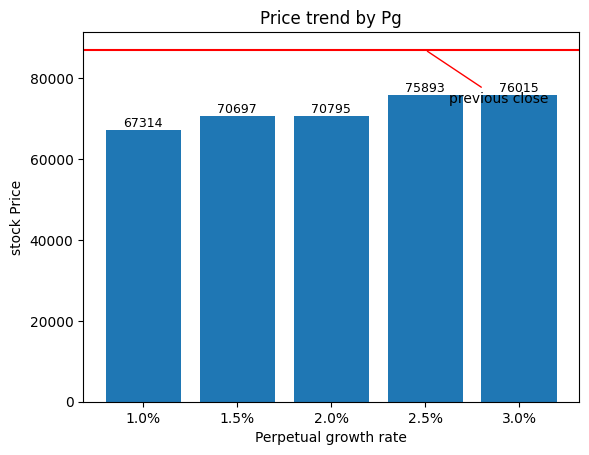

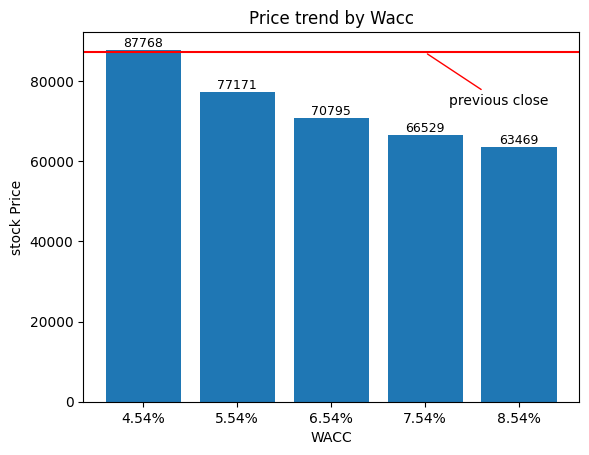

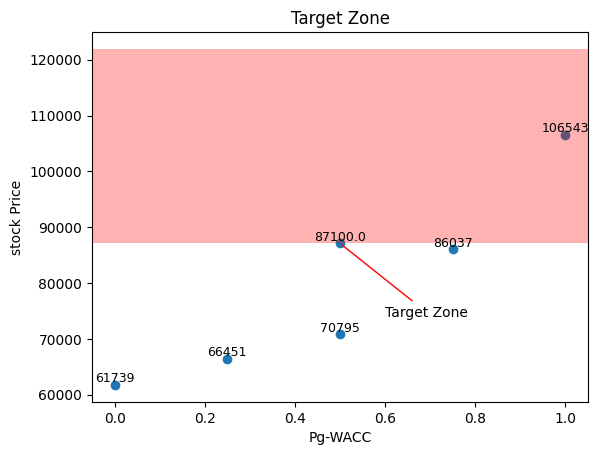

#3번 그래프: x축 진행방향으로 갈수록 pg와 wacc 격차가 축소됨


산출된 주가 - 현재 주가 = -16305.0
potentail = -18.72%
최종 의견: Sell

현재 가정하에 미래 현금흐름이 부족합니다.

수익성 개선이 필요합니다. 매출원가율, 판관비율을 줄일 필요가 있습니다.
재고자산 회전율을 높이고 매출채권 비중을 낮춰야합니다. 또 미지급금을 줄여서 최종적으로 NWC를 낮춰야합니다.

실행시간: 20.21085214614868
------------------------------------------------



In [81]:
import time

def checkTime(func):
    def new_func(*args):
        print("\n------------------------------------------------")
        start = time.time()
        func(*args)
        print("\n실행시간:",time.time()-start)
        print("------------------------------------------------\n")
    return new_func

@checkTime
def do_valuation():
    #try:
    # Step1 : loading F/S
    FS1_tables = load_FS()
    company = FS1_tables[0]
    IS = FS1_tables[1]
    BS = FS1_tables[2]
    CF = FS1_tables[3]

    # Preprocessing
    asset1 = step1(company, IS, BS, CF)
    tax = asset1.Basic_IS()
    asset1.Basic_CF()
    asset1.Dnwc()
    asset1.FCFF()
    fcff_table = asset1.mktable()

    # Step2 : Forecasting
    asset1 = step2(fcff_table, tax)
    asset1.ratios()
    asset1.Assume()
    forecast = asset1.forecast()

    # Step3 : WACC
    asset1 = WACC(company, BS, tax)
    asset1.risk_free_rate()
    asset1.market_risk_premium()
    asset1.beta()
    asset1.cost_debt()
    wacc = asset1.wacc()

    # Step4: DCF
    asset1 = DCF(forecast, wacc, company)
    asset1.pv_FCFF()
    asset1.TV()
    asset1.NOA_IBD(BS)
    stockvalue, table = asset1.EV()
    
    # Step5: Basic Analysis
    asset1 = analysis(company, stockvalue, BS, forecast, table)
    asset1.today_stockprice()
    asset1.visualization()
    cons = asset1.concensus()
    asset1.advise()

    # Step6: MonteCarlo Simulation

       
    #except:
        #print("\n데이터를 불러오는데 문제가 있습니다. 보통 필요한 정보가 누락된 경우에 발생합니다가 있습니다. 혹은 종목 코드를 다시 입력해보십시오.")
    
   
if __name__ == "__main__":
    do_valuation()